In [181]:
import random
import torch
from torch.optim import Optimizer
import torch.nn as nn
from torch.func import vmap
import math
import numpy as np
import matplotlib.pyplot as plt

In [182]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [183]:
class LSQ(nn.Module):
    def __init__(self, n_features):
        super(LSQ, self).__init__()
        self.w = torch.nn.Linear(n_features, 1, bias=False)

    def forward(self, x):
        return self.w(x)

In [184]:
# def eval_loss(pred, true): 
#     n_train = pred.shape[0]
#     loss = 0.5 * torch.sum((pred - true) ** 2) / n_train
#     return loss

In [185]:
n_train = 5000
n_features = 100
n_iters = 30

weight = np.random.normal(size=n_features)

Xtrain = np.random.normal(size = (n_train, n_features))
ytrain = (Xtrain @ weight)[: , np.newaxis]

In [186]:
class SketchySGD(Optimizer):
    """Implements SketchySGD. We assume that there is only one parameter group to optimize.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        rank (int): sketch rank
        rho (float): regularization
        lr (float): learning rate
        weight_decay (float): weight decay parameter
        hes_update_freq (int): how frequently we should update the Hessian approximation
        momentum (float): momentum parameter
        proportional (bool): option to maintain lr to rho ratio, even when lr decays
        chunk_size (int): number of Hessian-vector products to compute in parallel
                          if set to None, binary search will be used to find the maximally allowed value
    """
    def __init__(self, params, rank = 100, rho = 0.1, lr = 0.01, weight_decay = 0.0,
                 hes_update_freq = 100, momentum = 0.0, proportional = False, chunk_size = None):
        # initialize the optimizer    
        defaults = dict(rank = rank, rho = rho, lr = lr, weight_decay = weight_decay, 
                        hes_update_freq = hes_update_freq, proportional = proportional,
                        chunk_size = chunk_size)
        self.rank = rank
        self.hes_update_freq = hes_update_freq
        self.proportional = proportional
        self.chunk_size = chunk_size
        self.ratio = rho / lr
        self.hes_iter = 0
        self.U = None
        self.S = None
        self.counter = 0
        self.momentum = momentum
        self.momentum_buffer = None
        super(SketchySGD, self).__init__(params, defaults)

    def step(self, closure = None):
        loss = None
        grad_tuple = None
        if closure is not None:
            with torch.enable_grad():
                loss, grad_tuple = closure()

        # update Hessian approximation, if needed
        g = torch.cat([gradient.view(-1) for gradient in grad_tuple if gradient is not None])
        if self.hes_iter % self.hes_update_freq == 0:
            params = []

            for group in self.param_groups:
                for p in group['params']:
                    params.append(p)

            # update preconditioner
            self._update_preconditioner(params, g)

        g = g.detach()

        if self.hes_iter == 0:
            print(f"gradient at initialization: {g}")

        # update momentum buffer
        if self.momentum_buffer is None: 
            self.momentum_buffer = g
        else:
            self.momentum_buffer = self.momentum * self.momentum_buffer + g

        # one step update
        for group in self.param_groups:
            lr = group['lr']
            weight_decay = group['weight_decay']

            # Adjust rho to be proportional to lr, if necessary
            if self.proportional:
                rho = lr * self.ratio
            else:
                rho = group['rho']

            # compute gradient as a long vector
            # g = torch.cat([p.grad.view(-1) for p in group['params'] if p.grad is not None]) # only get gradients if they exist!
            # calculate the search direction by Nystrom sketch and solve
            UTg = torch.mv(self.U.t(), self.momentum_buffer) 
            g_new = torch.mv(self.U, (self.S + rho).reciprocal() * UTg) + self.momentum_buffer / rho - torch.mv(self.U, UTg) / rho
            
            ls = 0
            # update model parameters
            for p in group['params']:
                gp = g_new[ls:ls+torch.numel(p)].view(p.shape)
                ls += torch.numel(p)
                p.data.add_(-lr * (gp + weight_decay * p.data)) # use weight decay (not same as L2 reg.)
        
        self.hes_iter += 1

        return loss
    
    def _update_preconditioner(self, params, gradsH):
        p = gradsH.shape[0]
        # Generate test matrix (NOTE: This is transposed test matrix)
        Phi = (torch.randn(self.rank, p) / (p ** 0.5)).to(params[0].device)
        Phi = torch.linalg.qr(Phi.t(), mode='r')[1].t()
        # Calculate sketch (NOTE: This is transposed sketch)
        # Use binary search to find the maximally allowed chunck_size (only when chunck_size has not been set)
        if self.chunk_size is None: 
            # start with the rank
            self.chunk_size = self.rank
            # set bounds for the search
            max_size = self.rank
            min_size = 1
            while(True): 
                # update lower bound if attempted computation was successful
                try: 
                    Y = self._hvp_vmap(gradsH, params)(Phi)
                    min_size = self.chunk_size
                    # search range has converged to a single point
                    if max_size - min_size <= 1: 
                        margin_factor = 1.0
                        # grab memory information
                        free_mem, total_mem = torch.cuda.mem_get_info()
                        if free_mem / total_mem < 0.05: 
                            margin_factor = 0.95
                        # create some safety margin (e.g. 95% of the found size)
                        self.chunk_size = max(1, int(margin_factor * min_size))
                        torch.cuda.empty_cache()
                        break
                # update upper bound if attempted computation ran out of memory
                except RuntimeError as e:
                    if str(e).startswith('CUDA out of memory.') and self.chunk_size > 1:
                        max_size = self.chunk_size
                        torch.cuda.empty_cache()
                    # terminate if other runtime error occured or chunk_size = 1 still ran out of memory
                    else: 
                        raise e
                # halve the search range
                self.chunk_size = int(0.5 * (min_size + max_size))
            # report final chunk size
            print(f'SketchySGD: chunk size has been set to {self.chunk_size}.')
        # use previously set chunk size
        else: 
            Y = self._hvp_vmap(gradsH, params)(Phi)
            Y2 = self._hvp_vmap(gradsH, params)(torch.eye(p).to(params[0].device))
            print(f'True Hessian = {Y2}')

        # Calculate shift
        shift = torch.finfo(Y.dtype).eps
        Y_shifted = Y + shift * Phi
        # Calculate Phi^T * H * Phi (w/ shift) for Cholesky
        choleskytarget = torch.mm(Y_shifted, Phi.t())
        # Perform Cholesky, if fails, do eigendecomposition
        # The new shift is the abs of smallest eigenvalue (negative) plus the original shift
        try:
            C = torch.linalg.cholesky(choleskytarget)
        except:
            # eigendecomposition, eigenvalues and eigenvector matrix
            eigs, eigvectors = torch.linalg.eigh(choleskytarget)
            shift = shift + torch.abs(torch.min(eigs))
            # add shift to eigenvalues
            eigs = eigs + shift
            # put back the matrix for Cholesky by eigenvector * eigenvalues after shift * eigenvector^T 
            C = torch.linalg.cholesky(torch.mm(eigvectors, torch.mm(torch.diag(eigs), eigvectors.T)))

        try: 
            B = torch.linalg.solve_triangular(C, Y_shifted, upper = False, left = True)
        # temporary fix for issue @ https://github.com/pytorch/pytorch/issues/97211
        except: 
            B = torch.linalg.solve_triangular(C.to('cpu'), Y_shifted.to('cpu'), upper = False, left = True).to(C.device)
        _, S, UT = torch.linalg.svd(B, full_matrices = False) # B = V * S * U^T b/c we have been using transposed sketch
        self.U = UT.t()
        self.S = torch.max(torch.square(S) - shift, torch.tensor(0.0))

        print(f'Low-rank approximation (without rho) = {torch.mm(torch.mm(self.U, torch.diag(self.S)), self.U.t())}')

    def _hvp_vmap(self, grad_params, params):
        return vmap(lambda v: hvp(grad_params, params, v), in_dims = 0, chunk_size=self.chunk_size)

def hvp(grad_params, params, v):
    Hv = torch.autograd.grad(grad_params, params, grad_outputs = v,
                              retain_graph = True)
    Hv = tuple(Hvi.detach() for Hvi in Hv)
    return torch.cat([Hvi.reshape(-1) for Hvi in Hv])

def group_product(xs, ys):
    return sum([torch.sum(x * y) for (x, y) in zip(xs, ys)])

def normalize(v):
    s = torch.sqrt(group_product(v, v))
    v = [x / (s + 1e-6) for x in v]
    return v

In [188]:
model = LSQ(n_features)

optimizer = SketchySGD(model.parameters(), lr=1e-1, rank=100, rho=1e-6, chunk_size=5, hes_update_freq=1, momentum=0)

loss_hist = []
step_size_hist = []

Xt = torch.tensor(Xtrain, dtype=torch.float)
yt = torch.tensor(ytrain, dtype=torch.float)

torch.nn.init.zeros_(model.w.weight)

loss_function = nn.MSELoss()

for i in range(n_iters):
    model.train()
    def closure(): 
        optimizer.zero_grad()
        
        output = model(Xt)
        loss = loss_function(output, yt)
        if isinstance(optimizer, SketchySGD): 
            grad_tuple = torch.autograd.grad(loss, model.parameters(), create_graph=True)
            return loss, grad_tuple   
        else:
            loss.backward()
        return loss

    optimizer.step(closure)
    # print(f"new weights: {model.w.weight}")
    # cur_step_size = None
    # if isinstance(optimizer, SketchySGD): 
    #     cur_step_size = optimizer.state_dict()['state'][0]['step_size']
    # if isinstance(optimizer, torch.optim.LBFGS): 
    #     cur_step_size = optimizer.state_dict()['state'][0]['t']
    
    model.eval()
    output = model(Xt)
    loss = loss_function(output, yt).item()
    loss_hist.append(loss)

    print(f"loss: {loss}")
    print(f"actual loss: {0.5 * torch.mm(Xt, model.w.weight.T).sub(yt).pow(2).mean() / n_train}")
    # if cur_step_size is not None: 
    #     step_size_hist.append(cur_step_size)

True Hessian = tensor([[ 1.9792,  0.0176, -0.0237,  ..., -0.0357,  0.0166,  0.0332],
        [ 0.0176,  2.0369,  0.0089,  ...,  0.0099, -0.0065, -0.0325],
        [-0.0237,  0.0089,  2.0752,  ..., -0.0076,  0.0044,  0.0117],
        ...,
        [-0.0357,  0.0099, -0.0076,  ...,  2.0522,  0.0069, -0.0181],
        [ 0.0166, -0.0065,  0.0044,  ...,  0.0069,  1.9179, -0.0469],
        [ 0.0332, -0.0325,  0.0117,  ..., -0.0181, -0.0469,  1.9951]])
Low-rank approximation (without rho) = tensor([[ 1.9792,  0.0176, -0.0237,  ..., -0.0357,  0.0166,  0.0332],
        [ 0.0176,  2.0369,  0.0089,  ...,  0.0100, -0.0065, -0.0325],
        [-0.0237,  0.0089,  2.0752,  ..., -0.0076,  0.0044,  0.0118],
        ...,
        [-0.0357,  0.0100, -0.0076,  ...,  2.0521,  0.0068, -0.0201],
        [ 0.0166, -0.0065,  0.0044,  ...,  0.0068,  1.9177, -0.0491],
        [ 0.0332, -0.0325,  0.0118,  ..., -0.0201, -0.0491,  1.9958]])
gradient at initialization: tensor([-3.5098, -0.8086, -2.2495, -4.4994, -3.996

In [189]:
np.sum(np.square(ytrain - Xtrain @ weight)) / n_train

1024630.8334019077

In [190]:
print(f"gradient of loss function at 0 = {2 * -Xtrain.T @ ytrain / n_train}")

gradient of loss function at 0 = [[-3.50980785]
 [-0.80856654]
 [-2.24949989]
 [-4.49936928]
 [-3.99599767]
 [ 1.84407324]
 [-1.68642628]
 [ 0.88081046]
 [ 0.63077351]
 [-0.80449884]
 [-0.10487917]
 [-2.94631201]
 [-1.61747569]
 [-0.89529129]
 [-0.75374459]
 [-0.63781025]
 [-3.19499123]
 [ 0.48344918]
 [-0.86577851]
 [ 2.11187996]
 [ 5.30796451]
 [-1.53338786]
 [-1.82679659]
 [ 1.12260823]
 [-4.51760161]
 [ 3.00177458]
 [ 0.21780347]
 [ 0.3146846 ]
 [-2.61681176]
 [-2.93555551]
 [-0.01832597]
 [-0.68875921]
 [ 1.88163691]
 [ 4.12919686]
 [ 0.74330581]
 [-0.62440497]
 [-2.33251757]
 [-2.23836417]
 [ 0.70230764]
 [ 0.82255751]
 [ 2.16085296]
 [ 2.66812308]
 [ 3.66481346]
 [-3.92013085]
 [ 0.88257894]
 [ 1.03856916]
 [ 2.7597351 ]
 [-1.22528283]
 [ 3.27964368]
 [ 0.26857325]
 [ 1.92192018]
 [-0.76638045]
 [ 0.98503741]
 [ 2.67978158]
 [-0.06389895]
 [-1.29241137]
 [-0.38702559]
 [-0.7419447 ]
 [ 1.7138443 ]
 [ 0.57477444]
 [ 1.31440639]
 [ 0.68825947]
 [ 1.66535874]
 [ 3.38836009]
 [-0.30

In [191]:
print(f"hessian of loss function = {2 * Xtrain.T @ Xtrain / n_train}")

hessian of loss function = [[ 1.97923935  0.01763496 -0.02365339 ... -0.03566987  0.01661763
   0.03322379]
 [ 0.01763496  2.03689437  0.00891041 ...  0.00994972 -0.00651575
  -0.03246954]
 [-0.02365339  0.00891041  2.07515238 ... -0.00761399  0.00441863
   0.01171637]
 ...
 [-0.03566987  0.00994972 -0.00761399 ...  2.05216389  0.00693142
  -0.01805839]
 [ 0.01661763 -0.00651575  0.00441863 ...  0.00693142  1.91793718
  -0.04685423]
 [ 0.03322379 -0.03246954  0.01171637 ... -0.01805839 -0.04685423
   1.99513691]]


[91.20142364501953, 92.0755844116211, 80.40280151367188, 68.05592346191406, 54.831600189208984, 48.860355377197266, 43.5271110534668, 34.8642463684082, 31.243240356445312, 27.286396026611328, 22.36285400390625, 20.486248016357422, 17.282045364379883, 16.17791175842285, 13.875542640686035, 12.379534721374512, 11.77461051940918, 9.914938926696777, 8.587862014770508, 8.663721084594727, 7.233959197998047, 6.371636867523193, 5.2600016593933105, 3.899461030960083, 3.398391008377075, 2.918346405029297, 2.710160255432129, 1.9602892398834229, 1.7145068645477295, 1.4743258953094482]


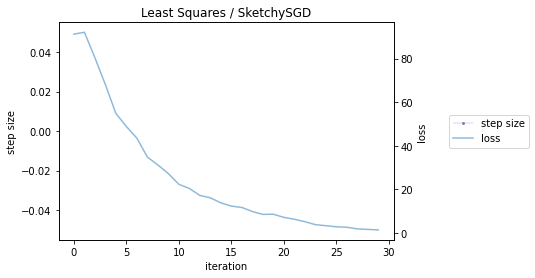

In [192]:
fig = plt.figure()

ax1 = fig.add_subplot()
step_line = ax1.plot([float(i) for i in step_size_hist], label='step size', color='C4', alpha=0.85, marker='o', markersize=2, linestyle='solid', linewidth=0.35)
ax1.set_ylabel('step size')
ax1.set_xlabel('iteration')

ax2 = plt.twinx()
loss_line = ax2.plot(loss_hist, label='loss', alpha=0.5)
ax2.set_ylabel('loss')

lines = step_line + loss_line
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center left', bbox_to_anchor=(1.15, 0.5))
ax1.set_title('Least Squares / SketchySGD')

print(loss_hist)